## Deploy  `CT Scan Body Part Detector` Model Package from AWS Marketplace 


This sample notebook shows you how to deploy [`CT Scan Body Part Detector`](http://aws.com) using Amazon SageMaker.

#### Pre-requisites:

1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.

1. Ensure that IAM role used has **AmazonSageMakerFullAccess**

1. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to [`CT Scan Body Part Detector`](http://aws.com). If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)

#### Contents:
1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Create an endpoint and perform real-time inference](#2.-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-input-payload)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Visualize output](#D.-Visualize-output)
   5. [Delete the endpoint](#E.-Delete-the-endpoint)
3. [Perform batch inference](#3.-Perform-batch-inference) 
4. [Clean-up](#4.-Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    2. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))
    

#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page <font color='red'> For Seller to update:[Title_of_your_product](Provide link to your marketplace listing of your product).</font>
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

In [3]:
model_package_arn = "arn:aws:sagemaker:us-west-2:535328050074:model-package/ct-scan-body-part-detector-v0"

In [4]:
! pip install SimpleITK
! pip install pydicom

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


<font color='red'> For Seller to update: Add all necessary imports in following cell, 
If you need specific packages to be installed, # try to provide them in this section, in a separate cell. </font>

In [5]:
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
from urllib.parse import urlparse
import numpy as np
import boto3

In [6]:
role = get_execution_role()

sagemaker_session = sage.Session()

bucket = sagemaker_session.default_bucket()
runtime = boto3.client("runtime.sagemaker")

print(role)
print(bucket)

arn:aws:iam::535328050074:role/MyAmazonSageMaker-ExecutionRole
sagemaker-us-west-2-535328050074


### 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

<font color='red'>For Seller to update: update values for four variables in following cell. 
Specify a model/endpoint name using only alphanumeric characters. </font>

In [7]:
model_name = "ct-scan-body-part-detector"

content_type = "application/json"

real_time_inference_instance_type = 'ml.m5.xlarge'
batch_transform_inference_instance_type = 'ml.m5.xlarge'

#### A. Create an endpoint

In [76]:
# create a deployable model from the model package.
model = ModelPackage(
    role=role, model_package_arn=model_package_arn, sagemaker_session=sagemaker_session
)

# Deploy the model
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)

-------------!

Once endpoint has been created, you would be able to perform real-time inference.

#### B. Create input payload

<font color='red'>For Seller to update: Add code snippet here that reads the input from 'data/input/real-time/' directory 
and converts it into format expected by the endpoint.</font>

In [77]:
import os
import requests
from base64 import b64encode,b64decode
import json
import zipfile
import numpy as np
import pydicom
import SimpleITK as sitk
import matplotlib.pyplot as plt

def resample_img(itk_image, out_spacing):
    
    # Resample images to out_spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

# custom resample
TARGET_XY_SIZE = 128
TARGET_Z_SIZE = 100
def imread(myinput,downsample=True):
    if isinstance(myinput,list):
        file_list = myinput
        dicom_list = []
        for image_file in file_list:
            ds=pydicom.dcmread(image_file)
            dicom_list.append((ds.InstanceNumber,image_file))
            dicom_list = sorted(dicom_list,key=lambda x:x[0])
        dicom_names = [x[1] for x in dicom_list]
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(dicom_names)
    else:
        file_path = myinput
        reader= sitk.ImageFileReader()
        reader.SetFileName(file_path)
        
    img_obj = reader.Execute()
    if downsample:
        spacing = list(img_obj.GetSpacing())
        size = list(img_obj.GetSize())
        
        # scale down to 128x128 for dimensions 0 and 1
        spacing[0] = spacing[0]*(size[0]/float(TARGET_XY_SIZE))
        spacing[1] = spacing[1]*(size[1]/float(TARGET_XY_SIZE))
        
        # scale to no more than 100 scans (for dimension 2)
        if size[2] < TARGET_Z_SIZE:
            factor = 1
        else:
            factor = size[2]/float(TARGET_Z_SIZE)
        spacing[2] = spacing[2]*factor
        
        img_obj = resample_img(img_obj, out_spacing=spacing)
        
    return img_obj

def imwrite(fpath,img_obj,use_compression=True):
    print(img_obj.GetSize())
    writer = sitk.ImageFileWriter()    
    writer.SetFileName(fpath)
    writer.SetUseCompression(use_compression)
    writer.Execute(img_obj)

def download_images(series_instance_uid,image_root="."):
    url = f"https://services.cancerimagingarchive.net/services/v4/TCIA/query/getImage?SeriesInstanceUID={series_instance_uid}"
    zip_file_path = os.path.join(image_root,series_instance_uid+'.zip')
    r = requests.get(url, allow_redirects=True)
    print(r.status_code)
    if r.status_code != 200:
        raise LookupError(f"ohoh {r.status_code}!")
    open(zip_file_path, 'wb').write(r.content)
    folder_path = os.path.join(image_root,series_instance_uid)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(folder_path)
    return folder_path

def convert_to_nifti(folder_path,series_instance_uid,image_root=None):
    file_list = [os.path.join(folder_path,x) for x in os.listdir(folder_path)]
    img_obj = imread(file_list)
    nii_gz_path = os.path.join(image_root,f'{series_instance_uid}.nii.gz')
    imwrite(nii_gz_path,img_obj)
    return nii_gz_path

ENCODING = 'utf-8'
def convert_to_json(input_file):
    with open(input_file, 'rb') as open_file:
        byte_content = open_file.read()
    base64_bytes = b64encode(byte_content)
    base64_string = base64_bytes.decode(ENCODING)
    myjson = {"niigz":base64_string}
    return myjson

def upload_to_s3(input_file):
    s3_prefix = 'ct-sample-images'
    rawdata_s3_prefix = '{}'.format(s3_prefix)
    s3_uri = sess.upload_data(path=input_file, key_prefix=rawdata_s3_prefix)
    return s3_uri
     

In [78]:
series_instance_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075'
image_root = "/tmp/myimages"
os.makedirs(image_root,exist_ok=True)
# download images from TCIA
folder_path = download_images(series_instance_uid,image_root=image_root)
nii_gz_path = convert_to_nifti(folder_path,series_instance_uid,image_root=image_root)
mypayload = convert_to_json(nii_gz_path)

(128, 128, 100)


In [79]:
with open('mypayload.txt','w') as f:
    f.write(json.dumps(mypayload))
with open('mypayload.txt','r') as f:
    mypayloadstr=f.read()

<Add code snippet that shows the payload contents>

In [80]:
!ls -lh

total 7.9M
-rw-rw-r-- 1 ec2-user ec2-user  51K Sep 13 18:11 ct-scan-body-part-detector-INIT.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 2.8M Sep 13 18:11 mypayload.txt
-rw-rw-r-- 1 ec2-user ec2-user 1.8M Sep 13 17:46 niigz-jsonlines.txt
-rw-rw-r-- 1 ec2-user ec2-user 1.1K Sep 13 17:53 niigz-jsonlines.txt.out
-rw-rw-r-- 1 ec2-user ec2-user  320 Sep 13 17:43 response_output.json
-rw-rw-r-- 1 ec2-user ec2-user 3.4M Sep 13 17:03 sagemaker-executed-notebook.ipynb


<font color='red'>For Seller to update: Ensure that file_name variable points to the payload you created. 
Ensure that output_file_name variable points to a file-name in which output of real-time inference needs to be stored.</font>

#### C. Perform real-time inference

<font color='red'>For Seller to update: review/update file_name, output_file name, custom attributes in following AWS CLI to perform a real-time inference using the payload file you created from 2.B </font>

In [81]:
!echo $sagemaker_session.boto_region_name

us-west-2


In [82]:
# $sagemaker_session.boto_region_name
!export model_name=ct-scan-body-part-detector \
 && export file_name=mypayload.txt \
 && export content_type=application/json \
 && export output_file_name=response_output.json \
 && echo $model_name $file_name $content_type $output_file_name \
 && aws sagemaker-runtime invoke-endpoint \
    --endpoint-name "$model_name" \
    --body "fileb://$file_name" \
    --content-type "$content_type" \
    --region "us-west-2" \
    "$output_file_name"

ct-scan-body-part-detector mypayload.txt application/json response_output.json
{
    "ContentType": "application/json",
    "InvokedProductionVariant": "AllTraffic"
}


#### D. Visualize output

<font color='red'>For Seller to update: Write code in following cell to display the output generated by real-time inference. This output must match with output available in data/output/real-time folder.</font>

In [83]:
!cat response_output.json

{"body_parts":{"abdomen":{"height":57.2,"unit":"mm"},"chest":{"height":207.9,"unit":"mm"},"head":{"height":0.0,"unit":"mm"},"lower_limb":{"height":0.0,"unit":"mm"},"neck":{"height":36.2,"unit":"mm"},"pelvis":{"height":0.0,"unit":"mm"}},"cap_completeness":{"abdomen":false,"chest":true,"pelvis":false},"head_first":true}


<font color='red'>For Seller to update: Get innovative! This is also your opportunity to show-off different capabilities of the model. 
E.g. if your model does object detection,  multi-class classification, or regression, repeat steps 2.B,2.C,2.D 
to show different inputs using files and outputs for different classes/objects/edge conditions.</font>

In [84]:
client = boto3.client('sagemaker-runtime')

endpoint_name = "ct-scan-body-part-detector"
content_type = "application/json"
accept = "application/json"
payload = mypayloadstr # Payload for inference.

response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType=content_type,
    Accept=accept,
    Body=payload
    )

print(response)
result = json.loads(response['Body'].read().decode())


{'ResponseMetadata': {'RequestId': '066ebe03-ea30-4ae6-8721-72a07e5fa56c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '066ebe03-ea30-4ae6-8721-72a07e5fa56c', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Mon, 13 Sep 2021 18:12:03 GMT', 'content-type': 'application/json', 'content-length': '320'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7fb245c0fef0>}


In [85]:
result

{'body_parts': {'abdomen': {'height': 57.2, 'unit': 'mm'},
  'chest': {'height': 207.9, 'unit': 'mm'},
  'head': {'height': 0.0, 'unit': 'mm'},
  'lower_limb': {'height': 0.0, 'unit': 'mm'},
  'neck': {'height': 36.2, 'unit': 'mm'},
  'pelvis': {'height': 0.0, 'unit': 'mm'}},
 'cap_completeness': {'abdomen': False, 'chest': True, 'pelvis': False},
 'head_first': True}

In [86]:
series_instance_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075'
folder_path = os.path.join(image_root,series_instance_uid)
file_list = [os.path.join(folder_path,x) for x in os.listdir(folder_path)]
img_obj = imread(file_list,downsample=False)

(0.609375, 0.609375, 1.25) (512, 512, 241)


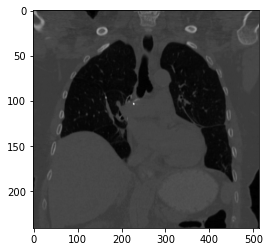

In [90]:
arr = sitk.GetArrayFromImage(img_obj)
spacing = img_obj.GetSpacing()
size = img_obj.GetSize()
print(spacing,size)
plt.imshow(arr[:,256,:].squeeze(),cmap='gray',aspect=spacing[2]/spacing[0])

#### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [91]:
model.sagemaker_session.delete_endpoint(model_name)
model.sagemaker_session.delete_endpoint_config(model_name)

In [92]:
### 3. Prepare for batch inference

In [93]:
# unseen dataset from tcia 
# collection id # anatomical-site # series-isntance-uid
# OPC-Radiomics, # head-and-neck # '1.3.6.1.4.1.14519.5.2.1.8666.3098.135047974513108102532692126459'
# CPTAC-SAR # whole-body # '1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668'
# COVID-19-NY-SBU # abdomen-pelvis # '1.3.6.1.4.1.14519.5.2.1.99.1071.20813077754558159326970236991440'

series_instance_uid_list = [
    "1.3.6.1.4.1.14519.5.2.1.8666.3098.135047974513108102532692126459",
    "1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668",
    "1.3.6.1.4.1.14519.5.2.1.99.1071.20813077754558159326970236991440",
]

In [96]:
niigz_list = []
image_root = "/tmp/myimages"
os.makedirs(image_root,exist_ok=True)
for suid in series_instance_uid_list:
    nii_gz_path = os.path.join(image_root,f'{suid}.nii.gz')
    folder_path = os.path.join(image_root,suid)
    if not os.path.exists(folder_path):
        folder_path = download_images(suid,image_root=image_root)        
    if not os.path.exists(nii_gz_path):
        nii_gz_path = convert_to_nifti(folder_path,suid,image_root=image_root)
    myjson = convert_to_json(nii_gz_path)
    niigz_list.append(myjson)
    
batch_file = 'niigz-jsonlines.txt'
with open(batch_file,'w') as f:
    for x in niigz_list:
        f.write(json.dumps(x)+'\n')

(128, 128, 100)
(128, 128, 100)
(128, 128, 100)


In [100]:
!ls -lh niigz-jsonlines.txt

-rw-rw-r-- 1 ec2-user ec2-user 6.5M Sep 13 18:14 niigz-jsonlines.txt


### 3. Perform batch inference

In this section, you will perform batch inference using multiple input payloads together. If you are not familiar with batch transform, and want to learn more, see these links:
1. [How it works](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-batch-transform.html)
2. [How to run a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html)

In [101]:
# upload the batch-transform job input files to S3
transform_input_file = batch_file
transform_input = sagemaker_session.upload_data(transform_input_file, key_prefix=model_name)
print("Transform input uploaded to " + transform_input)

Transform input uploaded to s3://sagemaker-us-west-2-535328050074/ct-scan-body-part-detector/niigz-jsonlines.txt


In [102]:
transform_output_folder = "batch-transform-output"
output_path="s3://{}/{}".format(bucket, transform_output_folder)

In [103]:
# Run the batch-transform job
transformer = model.transformer(
    1,batch_transform_inference_instance_type,
    output_path=output_path,
    assemble_with='Line',
    accept='application/jsonlines',
)
transformer.transform(transform_input, content_type='application/jsonlines', split_type='Line')
transformer.wait()

.................................f9y+Opd4bTyRfTbBhrlluFFZlPWquhOqAnzbSN4qKzpWNBbmwi5SNjZt6ULisgR9oF4lJXrjHmxJnQup7SSGYsMiD3F/kLNf2eWkRwkxKOG6l+yrrqt+IiNrQbKeOIJ+zIiRGKcZMiO6cNtQAvWklPki7BHJ+A0qzhZHysaI8onI11dO7N93Nm6WrSasC87p3OHyR3cA4LZFHKgs/61i5vGSRorQta4ikpqxmFSUeyRc+M5n6oDWWwDJ6c19aFZ+9Ax4WZ+JEJEnO1vLG29JU3s2O4qFnKpMmIaQ0stwtPuCSfA2JufQHJtdNtDbrunfjxz/TE6Wq0WKOM9Eti4qvpyEby3rrA7hhXeDSG7ThPr5IsM6Ikieg34di3x9RbF2FH2PLEugFUi5I8LdEeCzTzTMrBlThjoKGZUxt0MdklAW1EYX7JZG3msb6gIRoL7WRNOVmMc5+vaif/XYA9bwPcK2Ou2drRwVlKAiJ313ZzU04e0W6bfeXx6Adqmp1qgKmS0a8KPYP6LdqMGWSHu3lLUiydufbyykJMum2pJjyDAfSSHbRX2YmeWsCbsOCvjZIfYV2psSnZfiNOXVfo5FbWNXl1OnVxCZFgW1iswk9fDZ3M+Y6g6uoUT5YwAdkEGwi4x8jdEkOMmPK0M9fMx45c59hrsAjmhq0Ju9O5mlB3iBpIBo6aSw1qaOnYnAk5QldYO3deHvFK+iUpWNuXAF05MZt3BIuS6q32+AbxFxiQWH1mCJrRxLyO3LjROBfaRuEQDeNwAK2c3PHmkx8JOQDI5MevRxyn6kAfOGmB/v6fVNqEQBe8I+TOI83BKkK960QPWwqkudWQYIiE/fnFbFGRXsgA7XYHeyXKSFXx1Be9n6xBW8Pwr+qRd4QSkkdxNHiSXykXwGmqKz1awj/SU+2pNipDYaFv8l7F8t3QtRHJC9SRiRVboFVQ149DUyKopRIY7WDUn

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [105]:
# output is available on following path
transformer.output_path

's3://sagemaker-us-west-2-535328050074/batch-transform-output'

In [106]:
s3_client = sagemaker_session.boto_session.client('s3')
local_path = f'{batch_file}.out'
store_path = f"{transform_output_folder}/niigz-jsonlines.txt.out"
#store_path = f"{transform_output_folder}/{transformer.latest_transform_job.name}/{batch_file}.out"
print(store_path)
s3_client.download_file(bucket, store_path, local_path)
with open(local_path) as f:
    results = f.readlines()   
print("Transform results: \n{}".format(''.join(results)))

batch-transform-output/niigz-jsonlines.txt.out
Transform results: 
{"body_parts": {"abdomen": {"height": 0.0, "unit": "mm"}, "chest": {"height": 63.1, "unit": "mm"}, "head": {"height": 159.4, "unit": "mm"}, "lower_limb": {"height": 0.0, "unit": "mm"}, "neck": {"height": 109.6, "unit": "mm"}, "pelvis": {"height": 0.0, "unit": "mm"}}, "cap_completeness": {"abdomen": false, "chest": false, "pelvis": false}, "head_first": true}
{"body_parts": {"abdomen": {"height": 370.5, "unit": "mm"}, "chest": {"height": 156.0, "unit": "mm"}, "head": {"height": 156.0, "unit": "mm"}, "lower_limb": {"height": 1033.5, "unit": "mm"}, "neck": {"height": 97.5, "unit": "mm"}, "pelvis": {"height": 136.5, "unit": "mm"}}, "cap_completeness": {"abdomen": true, "chest": true, "pelvis": true}, "head_first": true}
{"body_parts": {"abdomen": {"height": 170.3, "unit": "mm"}, "chest": {"height": 95.2, "unit": "mm"}, "head": {"height": 0.0, "unit": "mm"}, "lower_limb": {"height": 0.0, "unit": "mm"}, "neck": {"height": 0.0

In [107]:
!cat niigz-jsonlines.txt.out

{"body_parts": {"abdomen": {"height": 0.0, "unit": "mm"}, "chest": {"height": 63.1, "unit": "mm"}, "head": {"height": 159.4, "unit": "mm"}, "lower_limb": {"height": 0.0, "unit": "mm"}, "neck": {"height": 109.6, "unit": "mm"}, "pelvis": {"height": 0.0, "unit": "mm"}}, "cap_completeness": {"abdomen": false, "chest": false, "pelvis": false}, "head_first": true}
{"body_parts": {"abdomen": {"height": 370.5, "unit": "mm"}, "chest": {"height": 156.0, "unit": "mm"}, "head": {"height": 156.0, "unit": "mm"}, "lower_limb": {"height": 1033.5, "unit": "mm"}, "neck": {"height": 97.5, "unit": "mm"}, "pelvis": {"height": 136.5, "unit": "mm"}}, "cap_completeness": {"abdomen": true, "chest": true, "pelvis": true}, "head_first": true}
{"body_parts": {"abdomen": {"height": 170.3, "unit": "mm"}, "chest": {"height": 95.2, "unit": "mm"}, "head": {"height": 0.0, "unit": "mm"}, "lower_limb": {"height": 0.0, "unit": "mm"}, "neck": {"height": 0.0, "unit": "mm"}, "pelvis": {"height": 235.5, "unit": "mm"}}, "cap_c

(0.976562, 0.976562, 2.0) (512, 512, 166) (1.3033333333333332, 5)
(0.9765625, 0.9765625, 2.0) (512, 512, 975) (1.3033333333333332, 5)
(0.782, 0.782, 3.0) (512, 512, 167) (1.3033333333333332, 5)


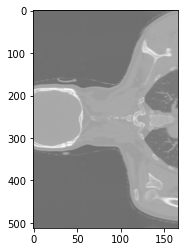

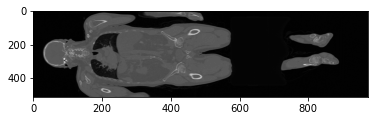

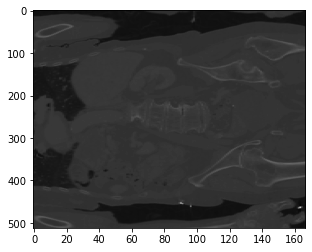

In [122]:
for n,series_instance_uid in enumerate(series_instance_uid_list):

    folder_path = os.path.join(image_root,series_instance_uid)
    file_list = [os.path.join(folder_path,x) for x in os.listdir(folder_path)]
    img_obj = imread(file_list,downsample=False)

    arr = sitk.GetArrayFromImage(img_obj)
    spacing = img_obj.GetSpacing()
    size = img_obj.GetSize()
    print(spacing,size,figsize)
    plt.figure(n)
    plt.imshow(arr[:,256,:].squeeze().T,cmap='gray',aspect=spacing[0]/spacing[2])

<font color='red'>For Seller to update: Add code that displays output generated by the batch transform job available in S3. 
This output must match the output available in data/output/batch folder.</font>

### 4. Clean-up

#### A. Delete the model

In [123]:
model.delete_model()

ClientError: An error occurred (ValidationException) when calling the DeleteModel operation: Could not find model "arn:aws:sagemaker:us-west-2:535328050074:model/ct-scan-body-part-detector-v0-2021-09-13-18-14-58-647".

#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

